In [2]:
import pandas as pd
import numpy as np
import scipy

from statsmodels.stats.multitest import fdrcorrection,multipletests

# Set the default font to Arial
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

## Parameters

In [3]:
# The filtering based on hotspots.
filter_version = 'including'  # 'including', 'excluding', 'only'
list_filter_versions = ['including', 'excluding', 'only']

INDEL_PREFIX = {
        'including':'indels/indels.denovo_', 
        'excluding':'indels/indels.exclHotspots.denovo_', 
        'only':'indels/indels.onlyHotspots.denovo_' 
    }[filter_version]

FREQS_PREFIX = {
        'including':'tables/freqs.denovo_indels.', 
        'excluding':'tables/freqs.exclHotspots.', 
        'only':'tables/freqs.onlyHotspots.' 
    }[filter_version]


# The 3 species.
list_species = ['mouse','macaque','human']
# The alignment chosen.
alignment = 'chrM'
# Dictionary of tissues per species.
dict_tissues =  {
                    'mouse':['Oo', 'M', 'Br'], 
                    'macaque':['Oo', 'M', 'Li'],
                    'human':['Oo', 'Sa', 'Bl'],
                }

# Import indels for 3 species

In [4]:
def get_indels(filter_version):
    # Combine indels for the three species.
    INDEL_PREFIX = {
        'including':'indels/indels.denovo_', 
        'excluding':'indels/indels.exclHotspots.denovo_', 
        'only':'indels/indels.onlyHotspots.denovo_' 
    }
    list_df = []
    for species in list_species:
        df = pd.read_table( f'{INDEL_PREFIX[filter_version]}{alignment}_{species}.tab' )
        list_df.append( df )
    df_indels = pd.concat(list_df)
    return df_indels

df_indels = get_indels('including')
df_indels

,CHROM,POS,REF,ALT,INFO,SRR_ID,value,Species,AC,AF,...,Pedigree,Version,relin_POS,Tissue_type,Classification,Mutation_ID,Pedigree_shared,Filter_ID,Region,Region_size
0,chrM,12343,AT,A,SB=2.42169;AF=0.00495049;AC=0,SRR10068699,.:1:0.00495049:2.42169,mouse,1.0,0.004950,...,G129,original,NaN,germline,Germline de novo,12343_AT_A,Unique to Individual,G133p4_12343,non-D-loop,15423
1,chrM,13053,T,TC,SB=2.11058;AF=0.00329761;AC=0,SRR10068701,.:2:0.00115607:2.64192,mouse,2.0,0.001156,...,G129,original,NaN,germline,Germline de novo,13053_T_TC,Between pedigrees,G133p4_13053,non-D-loop,15423
2,chrM,14806,CACCCCTACTATACAATCAAAGATATCCTAGGTATCCTAATCATAT...,C,SB=2.57858;AF=0.000629327;AC=0,SRR10068701,.:1:0.000629327:2.57858,mouse,1.0,0.000629,...,G129,original,NaN,germline,Germline de novo,14806_CACCCCTACTATACAATCAAAGATATCCTAGGTATCCTAA...,Unique to Individual,G133p4_14806,non-D-loop,15423
3,chrM,14640,A,AG,SB=1.61939;AF=0.00191388;AC=0,SRR10068702,.:2:0.00191388:1.61939,mouse,2.0,0.001914,...,G129,original,NaN,somatic,Somatic de novo,14640_A_AG,Unique to Individual,G133p4_14640,non-D-loop,15423
4,chrM,5171,G,GA,SB=2.50905;AF=0.00293255;AC=0,SRR10068703,.:2:0.0034904:3.49031,mouse,2.0,0.003490,...,G129,original,NaN,somatic,Somatic de novo,5171_G_GA,Between pedigrees,G133p4_5171,non-D-loop,15423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,chrM,864,A,AATGTT,SB=2.38069;AF=0.000582072;AC=0,hs006_Oo3,.:1:0.000582072:2.38069,human,1.0,0.000582,...,NaN,relin,9034.0,germline,Germline de novo,864_A_AATGTT,NaN,hs006_864,non-D-loop,15447
179,chrM,865,ACCCC,A,SB=2.38183;AF=0.000582072;AC=0,hs006_Oo3,.:1:0.000582072:2.38183,human,1.0,0.000582,...,NaN,relin,9035.0,germline,Germline de novo,865_ACCCC_A,NaN,hs006_865,non-D-loop,15447
180,chrM,954,A,AAT,SB=1.92242;AF=0.00256082;AC=0,hs010_Oo6,.:2:0.00256082:1.92242,human,2.0,0.002561,...,NaN,relin,9124.0,germline,Germline de novo,954_A_AAT,NaN,hs010_954,non-D-loop,15447
181,chrM,960,TCCC,T,SB=1.79519;AF=0.00258065;AC=0,hs010_Oo6,.:2:0.00258065:1.79519,human,2.0,0.002581,...,NaN,relin,9130.0,germline,Germline de novo,960_TCCC_T,NaN,hs010_960,non-D-loop,15447


# Import annotations and seq depths

In [5]:
def get_annots():
    annots = pd.read_table(f"tables/annotations.seqDepth.{alignment}.txt")
    return annots

annots = get_annots()
annots

,SRR_ID,Sample_ID,Individual,Tissue,Tissue_alt,Species,Age_group,Age,MeanReadDepth,Nucleotides
0,SRR10068699,G133p4_Oo2,G133p4,Oo,Oo2,mouse,Younger,0.083333,143.790061,2343778
1,SRR10068701,G133p4_Oo,G133p4,Oo,Oo,mouse,Younger,0.083333,1627.007669,26520225
2,SRR10068702,G133p4_M,G133p4,M,M,mouse,Younger,0.083333,1146.431288,18686830
3,SRR10068703,G133p4_Br,G133p4,Br,Br,mouse,Younger,0.083333,698.298712,11382269
4,SRR10068705,G133p3_Oo3,G133p3,Oo,Oo3,mouse,Younger,0.083333,116.046564,1891559
...,...,...,...,...,...,...,...,...,...,...
489,hs023_Oo1,hs023_Oo1,hs023,Oo,Oo1,human,Intermediate,33.000000,1959.128734,32460804
490,hs023_Oo2,hs023_Oo2,hs023,Oo,Oo2,human,Intermediate,33.000000,1087.038083,18011134
491,hs023_Oo3,hs023_Oo3,hs023,Oo,Oo3,human,Intermediate,33.000000,2201.843020,36482337
492,hs023_Oo4,hs023_Oo4,hs023,Oo,Oo4,human,Intermediate,33.000000,1130.984127,18739276


# Compute mutation frequencies by individual

In [6]:
def get_indiv_freqs(df_indels):
    # Import annotations.
    annots = get_annots()
    # Sum nucleotides per condition (age group, tissue) and individual.
    nucl = annots.groupby(['Species', 'Age_group', 'Age', 'Tissue', 'Individual'])['Nucleotides'].sum().reset_index(name='Nucleotides_per_tissue')
    
    # Compute the total genome frequencies by grouping by the same columns as the D-loop and non-D-loop frequencies
    no_mutx = df_indels.groupby(['Species', 'Age_group', 'Tissue', 'Individual']).size().reset_index(name='No_mutations')

    # Merge mutations and nucleotides.
    indiv_freqs = pd.merge(nucl,no_mutx, how='left')
    indiv_freqs['No_mutations'] = indiv_freqs['No_mutations'].fillna(0)

    # Compute frequency by individual and condition.
    indiv_freqs['Frequency'] = indiv_freqs['No_mutations'] / (indiv_freqs['Nucleotides_per_tissue'])

    # # Drop rows where Frequency is 0
    # indiv_freqs = indiv_freqs[indiv_freqs['Frequency'] != 0]
    
    return indiv_freqs

df_freqs = get_indiv_freqs(df_indels)
df_freqs

df_younger = df_freqs[df_freqs['Age_group']=='Younger']
df_younger

,Species,Age_group,Age,Tissue,Individual,Nucleotides_per_tissue,No_mutations,Frequency
23,human,Younger,20.000000,Oo,hs017,77077442,3.0,3.892189e-08
24,human,Younger,24.000000,Oo,hs005,59006342,4.0,6.778932e-08
25,human,Younger,24.000000,Sa,hs005,3860695,2.0,5.180414e-07
26,human,Younger,25.000000,Bl,hs006,999639,0.0,0.000000e+00
27,human,Younger,25.000000,Oo,hs006,155325033,6.0,3.862867e-08
...,...,...,...,...,...,...,...,...
237,mouse,Younger,0.083333,Oo,G137p3,39681520,10.0,2.520065e-07
238,mouse,Younger,0.083333,Oo,G137p5,8784188,3.0,3.415227e-07
239,mouse,Younger,0.083333,Oo,G139p1,10572417,2.0,1.891715e-07
240,mouse,Younger,0.083333,Oo,G140p6,23620269,6.0,2.540191e-07


# Test of normality

In [7]:
from scipy.stats import shapiro
import pandas as pd

def test_normality(df_in):
    '''
    The Shapiro-Wilk test is a hypothesis test that is applied to a sample with a null hypothesis that the sample has been generated from a normal distribution. If the p-value is low, we can reject such a null hypothesis and say that the sample has not been generated from a normal distribution.
    '''
    results = []

    # Parameters.
    for species in list_species:
        df = df_in[df_in['Species'] == species]
        dict_tissues = { 'mouse':['Oo','M','Br'], 'macaque':['Oo','M','Li'], 'human':['Oo','Sa','Bl'] }

        # Perform Shapiro-Wilk test for normality on the frequency distributions by tissue
        tissues = dict_tissues[species]
        for tissue in tissues:
            tissue_data = df[df['Tissue'] == tissue]['Frequency']
            stat, p_value = shapiro(tissue_data)
            results.append({
                "Species": species,
                "Tissue": tissue,
                "Shapiro-Wilk Test Statistic": stat,
                "p-value": p_value
            })

    # Convert results to a DataFrame for easy viewing
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
test_normality(df_younger)

,Species,Tissue,Shapiro-Wilk Test Statistic,p-value
0,mouse,Oo,0.810780,0.002862
1,mouse,M,0.915132,0.026336
2,mouse,Br,0.896605,0.009536
3,macaque,Oo,0.901526,0.260976
4,macaque,M,0.652034,0.000390
5,macaque,Li,0.839899,0.057605
6,human,Oo,0.783695,0.019104
7,human,Sa,0.822354,0.148726
8,human,Bl,0.836116,0.184317


# ANOVA and Kruskal-Wallis tests

In [8]:
import pandas as pd

import scipy.stats as stats

def test_anova(df_in):
    results = []

    # Parameters.
    for species in list_species:
        df = df_in[df_in['Species'] == species]
        dict_tissues = {'mouse': ['Oo', 'M', 'Br'], 'macaque': ['Oo', 'M', 'Li'], 'human': ['Oo', 'Sa', 'Bl']}

        # Perform ANOVA to compare distributions by tissue
        tissues = dict_tissues[species]
        anova_results = stats.f_oneway(
            df[df['Tissue'] == tissues[0]]['Frequency'],
            df[df['Tissue'] == tissues[1]]['Frequency'],
            df[df['Tissue'] == tissues[2]]['Frequency'],
        )

        # Store results
        results.append({
            'Species': species,
            'ANOVA statistic': anova_results.statistic,
            'p-value': anova_results.pvalue
        })

    # Convert results to a DataFrame for easy viewing
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
test_anova(df_younger)


,Species,ANOVA statistic,p-value
0,mouse,1.415104,0.249762
1,macaque,6.835645,0.004471
2,human,1.134157,0.351552


In [9]:
from scipy.stats import kruskal

def test_kruskal_wallis(df_in):
    # Initialize a list to store results
    results = []

    # Parameters.
    for species in list_species:
        df = df_in[df_in['Species'] == species]
        dict_tissues = {'mouse': ['Oo', 'M', 'Br'], 'macaque': ['Oo', 'M', 'Li'], 'human': ['Oo', 'Sa', 'Bl']}

        # Perform Kruskal-Wallis H-test to compare distributions by tissue
        tissues = dict_tissues[species]
        kruskal_results = kruskal(
            df[df['Tissue'] == tissues[0]]['Frequency'],
            df[df['Tissue'] == tissues[1]]['Frequency'],
            df[df['Tissue'] == tissues[2]]['Frequency']
        )

        # Append results for the species
        # Store results for each tissue
        for tissue in tissues:
            results.append({
                'Species': species,
                'Tissue': tissue,
                "Kruskal-Wallis statistic": kruskal_results.statistic,
                "p-value": kruskal_results.pvalue
            })


    # Convert results to a DataFrame for easy viewing
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
test_kruskal_wallis(df_younger)

,Species,Tissue,Kruskal-Wallis statistic,p-value
0,mouse,Oo,3.518825,0.172146
1,mouse,M,3.518825,0.172146
2,mouse,Br,3.518825,0.172146
3,macaque,Oo,13.573808,0.001128
4,macaque,M,13.573808,0.001128
5,macaque,Li,13.573808,0.001128
6,human,Oo,0.022388,0.988868
7,human,Sa,0.022388,0.988868
8,human,Bl,0.022388,0.988868


# Pairwise tests

## Tukey HSD

In [10]:
# Parametric follow-up to ANOVA.

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def pairwise_tests_macaque(df_in):
    list_df = []
    for species in ['mouse','macaque','human']:
        # Filter for pecies and specified tissues
        dict_tissues = {'mouse': ['Oo', 'M', 'Br'], 'macaque': ['Oo', 'M', 'Li'], 'human': ['Oo', 'Sa', 'Bl']}
        df = df_in[(df_in['Species'] == species) & (df_in['Tissue'].isin(dict_tissues[species]))]

        # Perform pairwise Tukey's HSD test
        tukey_results = pairwise_tukeyhsd(endog=df['Frequency'], groups=df['Tissue'], alpha=0.05)
        
        # Convert results to a DataFrame for easy viewing
        tukey_df = pd.DataFrame(data=tukey_results.summary().data[1:], columns=tukey_results.summary().data[0])

        tukey_df['Species'] = species

        list_df.append(tukey_df)

    tukey_df = pd.concat(list_df)
    return tukey_df

# Example usage
pairwise_tests_macaque(df_younger)


,group1,group2,meandiff,p-adj,lower,upper,reject,Species
0,Br,M,0.0,0.4105,-0.0,0.0,False,mouse
1,Br,Oo,0.0,0.2792,-0.0,0.0,False,mouse
2,M,Oo,0.0,0.9053,-0.0,0.0,False,mouse
0,Li,M,-0.0,0.1301,-0.0,0.0,False,macaque
1,Li,Oo,-0.0,0.0032,-0.0,-0.0,True,macaque
2,M,Oo,-0.0,0.2345,-0.0,0.0,False,macaque
0,Bl,Oo,-0.0,0.4166,-0.0,0.0,False,human
1,Bl,Sa,-0.0,0.9890,-0.0,0.0,False,human
2,Oo,Sa,0.0,0.5063,-0.0,0.0,False,human


## Wilcoxon

In [11]:
# Non-parametric follow-up to Kruskal-Wallis

from scipy.stats import wilcoxon

def wilcoxon_pairwise_tests(df_in):
    
    list_df = []
    for species in ['macaque']:
        # Tissues.
        dict_tissues = {'mouse': ['Oo', 'M', 'Br'], 'macaque': ['Oo', 'M', 'Li'], 'human': ['Oo', 'Sa', 'Bl']}
        
        # Filter for  species and specified tissues
        df = df_in[(df_in['Species'] == species) & (df_in['Tissue'].isin(dict_tissues[species]))]

        # Initialize a list to store results
        results = []
        # Perform pairwise Wilcoxon signed-rank tests
        tissues = dict_tissues[species]
        for i, tissue1 in enumerate(tissues):
            for j, tissue2 in enumerate(tissues):
                if i < j:
                    # data1 = df[df['Tissue'] == tissue1]
                    # data2 = df[df['Tissue'] == tissue2]
                    # data = pd.merge(data1,data2, how='outer')
                    # return data.shape[0], data1.shape[0],data2.shape[0]
                    data1 = df[df['Tissue'] == tissue1]['Frequency']
                    data2 = df[df['Tissue'] == tissue2]['Frequency']

                    # Test.
                    stat, p_value = wilcoxon(data1, data2)

                    if len(data1) > 0 and len(data2) > 0:
                        stat, p_value = wilcoxon(data1, data2)
                    else:
                        stat, p_value = float('nan'), float('nan')
                    results.append({
                        'Tissue1': tissue1,
                        'Tissue2': tissue2,
                        # 'Wilcoxon statistic': stat,
                        'Wilcoxon p-value': p_value
                    })

        # Convert results to a DataFrame for easy viewing
        wilcoxon_df = pd.DataFrame(results)

        wilcoxon_df['Species'] = species.capitalize()
        dict_tissue_names = {
                'Oo': 'Oocytes', 'M': 'Skeletal muscle', 'Br': 'Brain',
                'Li': 'Liver', 'Sa': 'Saliva', 'Bl': 'Blood'
            }
        wilcoxon_df['Tissue1'] = wilcoxon_df['Tissue1'].map(dict_tissue_names)
        wilcoxon_df['Tissue2'] = wilcoxon_df['Tissue2'].map(dict_tissue_names)

        list_df.append(wilcoxon_df)
    
    wilcoxon_df = pd.concat(list_df)
    return wilcoxon_df

# Example usage
wilcoxon_pairwise_tests(df_younger)

,Tissue1,Tissue2,Wilcoxon p-value,Species
0,Oocytes,Skeletal muscle,0.039062,Macaque
1,Oocytes,Liver,0.003906,Macaque
2,Skeletal muscle,Liver,0.097656,Macaque


## Test input data

/var/folders/fq/63_fsbc110s_4lv0n6kgz4900000gn/T/ipykernel_9548/1865186339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_younger['0_mutx'] = df_younger['No_mutations']==0


<Axes: xlabel='Tissue', ylabel='Frequency'>

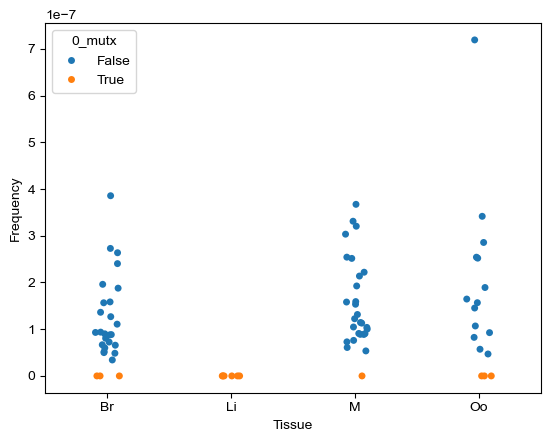

In [12]:
import seaborn as sns

df_younger['0_mutx'] = df_younger['No_mutations']==0

sns.stripplot(data=df_younger[df_younger['Species']=='mouse'], x='Tissue', y='Frequency', hue='0_mutx')

In [13]:
def get_group_freqs(filter_version='including'):
    # Get indels.
    indels = get_indels(filter_version)
    # Compute the total genome frequencies by grouping by the same columns as the D-loop and non-D-loop frequencies
    no_mutx = indels.groupby(['Species', 'Tissue', 'Age_group']).size().reset_index(name='No_mutations')
    # Import annotations.
    annots = get_annots()
    # Sum nucleotides per condition (age group, tissue) and individual.
    nucl = annots.groupby(['Species', 'Tissue', 'Age_group'])['Nucleotides'].sum().reset_index()
    # Merge.
    df = pd.merge(no_mutx, nucl, how='right')
    # Compute freqs.
    df = df.dropna(subset=['No_mutations'])
    df['Frequency'] = df['No_mutations'] / df['Nucleotides']
    return df
    



get_group_freqs()

,Species,Tissue,Age_group,No_mutations,Nucleotides,Frequency
0,human,Bl,Intermediate,6.0,5310791,1.129775e-06
1,human,Bl,Older,10.0,11250847,8.888220e-07
2,human,Bl,Younger,6.0,7738150,7.753791e-07
3,human,Oo,Intermediate,35.0,556737175,6.286629e-08
4,human,Oo,Older,57.0,539602351,1.056333e-07
5,human,Oo,Younger,45.0,451721281,9.961895e-08
6,human,Sa,Intermediate,11.0,9702348,1.133746e-06
7,human,Sa,Older,6.0,7567919,7.928203e-07
8,human,Sa,Younger,7.0,8775050,7.977163e-07
12,macaque,Li,Interm_1,235.0,315530912,7.447765e-07


In [14]:
annots[annots['Individual']=='G131p1']

,SRR_ID,Sample_ID,Individual,Tissue,Tissue_alt,Species,Age_group,Age,MeanReadDepth,Nucleotides
5,SRR10068708,G131p1_Br,G131p1,Br,Br,mouse,Younger,0.083333,255.781288,4169235
14,SRR10068719,G131p1_Br,G131p1,Br,Br,mouse,Younger,0.083333,221.555644,3611357
186,SRR10068916,G131p1_M,G131p1,M,M,mouse,Younger,0.083333,501.278405,8170838


In [15]:
pivot_df = df_younger[df_younger['Species']=='mouse'].pivot_table(index=['Species', 'Individual', 'Age_group', 'Age'], columns='Tissue', values='Frequency').reset_index()
pivot_df

Tissue,Species,Individual,Age_group,Age,Br,Li,M,Oo
0,mouse,G131p1,Younger,0.083333,3.855748e-07,NaN,3.671594e-07,NaN
1,mouse,G131p2,Younger,0.083333,1.960120e-07,NaN,1.142822e-07,NaN
2,mouse,G131p3,Younger,0.083333,1.565148e-07,NaN,2.541385e-07,0.000000e+00
3,mouse,G132p1,Younger,0.083333,6.008304e-08,NaN,1.046727e-07,NaN
4,mouse,G132p2,Younger,0.083333,8.843094e-08,NaN,1.581060e-07,NaN
5,mouse,G132p3,Younger,0.083333,2.402860e-07,NaN,1.002452e-07,0.000000e+00
6,mouse,G132p4,Younger,0.083333,4.988161e-08,NaN,3.203537e-07,0.000000e+00
7,mouse,G132p5,Younger,0.083333,0.000000e+00,NaN,8.899024e-08,8.251050e-08
8,mouse,G132p6,Younger,0.083333,9.001574e-08,NaN,1.038192e-07,1.644718e-07
9,mouse,G132p7,Younger,0.083333,1.583717e-07,NaN,1.590747e-07,1.452606e-07


## Kolmogorov-Smirnov, Mann Whitney U, Wilcoxon

In [19]:
from scipy.stats import ks_2samp, fisher_exact, wilcoxon, mannwhitneyu

def compare_tissue_frequencies(df_in):
    df = df_in.copy()

    def get_freqs_v2(df_in):
        df = df_in.copy()
        # Summarize # of mutations, nucleotides, ages.
        nucl = df.groupby(['Species','Tissue','Age_group'])['Nucleotides_per_tissue'].sum().reset_index(name='Nucleotides')
        mutx = df.groupby(['Species','Tissue','Age_group'])['No_mutations'].sum().reset_index()
        df = pd.merge(mutx,nucl)

        # Compute frequencies.
        df['Frequency'] = df['No_mutations'] / df['Nucleotides']

        # Filter for specific tissues per species
        dict_tissues = { 'mouse':['Oo','M','Br'], 'macaque':['Oo','M','Li'], 'human':['Oo','Sa','Bl'] }
        df = df[df.apply(lambda row: row['Tissue'] in dict_tissues[row['Species']], axis=1)]
        return df

    freqs_v2 = get_freqs_v2(df)
    
    # Parameters.
    results = []
    for species in list_species:
        # Tissue info.
        dict_tissues = { 'mouse':['Br','M','Oo'], 'macaque':['Oo','M','Li'], 'human':['Oo','Sa','Bl'] }
        tissues = dict_tissues[species]
        print(species)

        # Tissues as columns with freqs as values.
        pivot_df = df[df['Species']==species].pivot_table(index=['Species', 'Individual', 'Age_group', 'Age'], columns='Tissue', values='Frequency').reset_index()
        pivot_v2 = freqs_v2[freqs_v2['Species']==species].pivot_table(index=['Species', 'Age_group'], columns='Tissue', values=['No_mutations','Nucleotides']).reset_index()

        # Perform Kolmogorov-Smirnov test, Fisher's exact test, and Wilcoxon signed-rank test for each pair of tissues
        for i, tissue1 in enumerate(tissues):
            for j, tissue2 in enumerate(tissues):
                if i < j:
                    data = pivot_df[['Individual',tissue1,tissue2]].fillna(0)
                    data1 = data[tissue1]
                    data2 = data[tissue2]

                    mean1 = data1.mean()
                    mean2 = data2.mean()
                    fold_diff = mean2/mean1
                    # print( tissue1, mean1, tissue2, mean2)

                    # Mann-Whitney U test
                    mwu_stat, mwu_p_value = mannwhitneyu(data1, data2)

                    # Kolmogorov-Smirnov test
                    ks_stat, ks_p_value = ks_2samp(data1, data2)
                    
                    # # Wilcoxon signed-rank test
                    # if len(data1) == len(data2):
                    #     wilcoxon_stat, wilcoxon_p_value = wilcoxon(data1, data2)
                    # else:
                    #     wilcoxon_stat, wilcoxon_p_value = float('nan'), float('nan')

                    # Fisher's Exact test (uses other data).
                    mutx = pivot_v2['No_mutations']
                    nucl = pivot_v2['Nucleotides']
                    table = [[mutx[tissue1].sum(), nucl[tissue1].sum()],
                             [mutx[tissue2].sum(), nucl[tissue2].sum()]]
                    fisher_stat, fisher_p_value = fisher_exact(table, alternative='two-sided')
                    
                    results.append({
                        'Species': species,
                        'Tissue 1': tissue1,
                        'Mean frequency 1': mean1,
                        'Tissue 2': tissue2,
                        'Mean frequency 2': mean2,
                        'Fold difference (Tissue 2/ Tissue1)': fold_diff,
                        # 'Frequency1_A': mutx[tissue1].sum() / nucl[tissue1].sum(),
                        # 'Frequency2_A':  mutx[tissue2].sum() / nucl[tissue2].sum(),
                        # 'Frequency1_B': data1.median(),
                        # 'Frequency2_B': data2.median(),
                        # 'Fisher p-value': fisher_p_value,
                        # 'Wilcoxon p-value': wilcoxon_p_value,
                        # 'Kolmogorov-Smirnov p-value': ks_p_value,
                        'Mann-Whitney U p-value': mwu_p_value,
                    })


    # Convert results to a DataFrame for easy viewing
    results_df = pd.DataFrame(results)

    # Rename values.
    dict_tissue_names = {
                'Oo': 'Oocytes', 'M': 'Skeletal muscle', 'Br': 'Brain',
                'Li': 'Liver', 'Sa': 'Saliva', 'Bl': 'Blood'
            }
    results_df['Species'] = results_df['Species'].str.capitalize()
    results_df['Tissue 1'] = results_df['Tissue 1'].map(dict_tissue_names)
    results_df['Tissue 2'] = results_df['Tissue 2'].map(dict_tissue_names)

    def format_long_numbers(df, precision=2):
        """
        Format numbers in the dataframe:
        - Large numbers are formatted with commas (e.g., 1,000,000).
        - Floats smaller than 1 are displayed in scientific notation.
        - Precision for floats is controlled by the 'precision' parameter.
        """
        for col in df.select_dtypes(include=['float64']).columns:
            if 'Fold difference' not in col:
                df[col] = df[col].apply(lambda x: f"{x:,.{1+precision}f}" if x >= 0.01 else f"{x:.{precision}e}")
            elif 'Fold difference' in col:
                df[col] = df[col].apply(lambda x: f"{x:,.{1}f}" if x >= 0.01 else f"{x:.{precision}e}")
        return df
    
    results_df = format_long_numbers(results_df)
    
    return results_df

# Example usage
compare_tissue_frequencies(df_younger)

mouse
macaque
human


,Species,Tissue 1,Mean frequency 1,Tissue 2,Mean frequency 2,Fold difference (Tissue 2/ Tissue1),Mann-Whitney U p-value
0,Mouse,Brain,1.15e-07,Skeletal muscle,1.55e-07,1.3,0.049
1,Mouse,Brain,1.15e-07,Oocytes,1.03e-07,0.9,0.105
2,Mouse,Skeletal muscle,1.55e-07,Oocytes,1.03e-07,0.7,8.31e-03
3,Macaque,Oocytes,1.24e-07,Skeletal muscle,3.18e-07,2.6,0.042
4,Macaque,Oocytes,1.24e-07,Liver,5.51e-07,4.5,1.08e-03
5,Macaque,Skeletal muscle,3.18e-07,Liver,5.51e-07,1.7,0.027
6,Human,Oocytes,1.51e-07,Saliva,2.67e-07,1.8,0.095
7,Human,Oocytes,1.51e-07,Blood,2.95e-07,2.0,0.095
8,Human,Saliva,2.67e-07,Blood,2.95e-07,1.1,0.945


### Export as image

mouse
macaque
human


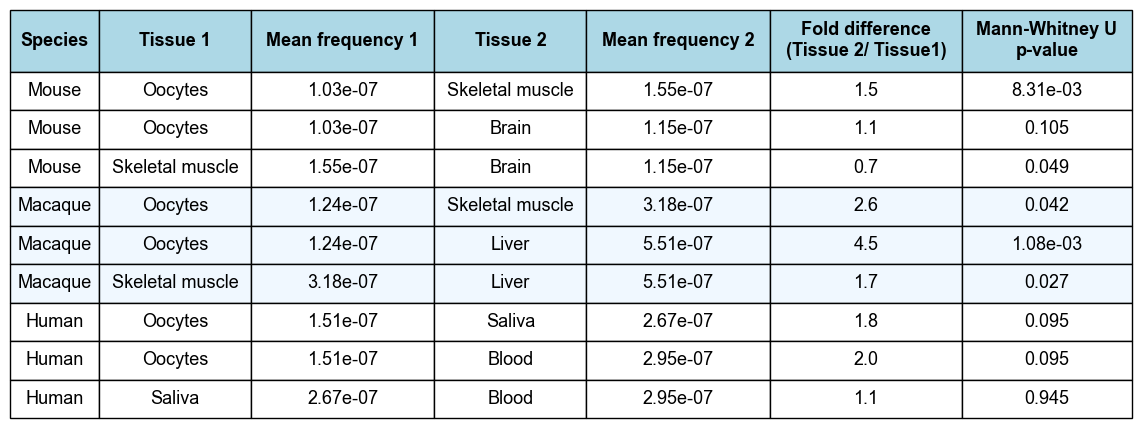

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# Set the default font to Arial
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

def format_long_numbers(df, precision=2):
    """
    Format numbers in the dataframe:
    - Large numbers are formatted with commas (e.g., 1,000,000).
    - Floats smaller than 1 are displayed in scientific notation.
    - Precision for floats is controlled by the 'precision' parameter.
    """
    for col in df.select_dtypes(include=['float64']).columns:
        if 'Fold difference' not in col:
            df[col] = df[col].apply(lambda x: f"{x:,.{precision}f}" if x >= 0.01 else f"{x:.{precision}e}")
    return df

def enforce_line_breaks_in_headers(df, max_width=20):
    """
    Enforces line breaks in column headers by inserting `\n` when the text exceeds `max_width`.
    """
    # Replace spaces with newlines if the text length exceeds max_width
    df.columns = [
        '\n'.join(textwrap.wrap(col, max_width)) if len(col) > max_width else col
        for col in df.columns
    ]
    return df

def export_table_as_png(df, file_prefix="table_custom_header.png", save=True):
    df = df.copy()

    df = format_long_numbers(df)

    df = enforce_line_breaks_in_headers(df)

    # Set the font to Arial and size to 10
    plt.rcParams["font.family"] = "Arial"
    fontsize = 12
    plt.rcParams["font.size"] = fontsize

    # Create the figure for the table
    plt.figure(figsize=(5, 2))  # Adjust size as needed

    # Create a table using pandas' built-in functionality
    ax = plt.gca()
    ax.axis('off')  # Turn off axes
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=['lightgrey']*len(df.columns))

    # Adjust column width.
    table.auto_set_column_width(col=list(range(len(df.columns))))

    # Scale the table (header and row scaling)
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header row
            cell.set_fontsize(fontsize)
            cell.set_text_props(weight='bold')
            cell.set_facecolor('lightblue')  # Optional: Set header row color
            cell.set_height(0.4)  # Increase the height of the header rows
        else:  # Data rows
            cell.set_fontsize(fontsize+1)
            cell.set_height(0.25)  # Increase the height of the rows
            cell.set_facecolor('white')  # Optional: Set data row color
            if df.iloc[i-1]["Species"] == "Macaque":  # Check if Species == Macaque
                cell.set_facecolor('#F0F8FF')  # Gainsboro (Light gray)

    # if save:
    #     # Save table as tsv.
    #     df.to_csv(f'plots/tsv/{file_prefix}.tsv', index=None, sep='\t')
    #     # Save the figure as a vectorized image.
    #     plt.savefig(f'plots/png/{file_prefix}.png', dpi=300, bbox_inches='tight')
    #     plt.savefig(f'plots/pdf/{file_prefix}.pdf', dpi=300, bbox_inches='tight')
    #     # plt.close()

# Export the result of test_kruskal_wallis(df_younger) as an image
pairwise_df = compare_tissue_frequencies(df_younger)
export_table_as_png(pairwise_df, "tableS2_younger_freqs_pairwise_tests")


# Reformat Kruskal-Wallis + Wilcoxon results

In [16]:
from scipy.stats import kruskal

def test_kruskal_wallis(df_in):
    # Initialize a list to store results
    results = []

    # Parameters.
    for species in list_species:
        df = df_in[df_in['Species'] == species]
        dict_tissues = {'mouse': ['Oo', 'M', 'Br'], 'macaque': ['Oo', 'M', 'Li'], 'human': ['Oo', 'Sa', 'Bl']}
        dict_tissue_names = {
            'Oo': 'Oocytes', 'M': 'Skeletal muscle', 'Br': 'Brain',
            'Li': 'Liver', 'Sa': 'Saliva', 'Bl': 'Blood'
        }

        # Perform Kruskal-Wallis H-test to compare distributions by tissue
        tissues = dict_tissues[species]
        kruskal_results = kruskal(
            df[df['Tissue'] == tissues[0]]['Frequency'],
            df[df['Tissue'] == tissues[1]]['Frequency'],
            df[df['Tissue'] == tissues[2]]['Frequency']
        )

        # Append results for the species
        # Store results for each tissue
        for tissue in tissues:
            results.append({
                'Species': species.capitalize(),
                'Tissue': dict_tissue_names[tissue],
                # "Kruskal-Wallis statistic": float(kruskal_results.statistic),
                "Kruskal-Wallis p-value": float(kruskal_results.pvalue),
                "Significance": ""
            })

    # Convert results to a DataFrame for easy viewing
    results_df = pd.DataFrame(results)

    # Function to assign stars based on p-value significance levels
    def assign_p_value_stars(df, p_value_col='Kruskal-Wallis p-value', thresholds=[0.001, 0.01, 0.05], stars=["***", "**", "*", "ns"]):
        """
        Assign stars based on p-value significance levels.
        """
        # Ensure thresholds and stars are aligned
        if len(stars) != len(thresholds) + 1:
            raise ValueError("The length of `stars` must be one greater than `thresholds`.")
        
        # Function to assign stars based on p-value
        def get_stars(p):
            for i, threshold in enumerate(thresholds):
                if p <= threshold:
                    return stars[i]
            return stars[-1]  # No significance
        
        # Apply the star assignment function to the p_value column
        df['Significance'] = df[p_value_col].apply(get_stars)
        
        return df

    # Assign stars to the results DataFrame
    results_df = assign_p_value_stars(results_df)

    # Wilcoxon pairwise results.
    wilcoxon_df = wilcoxon_pairwise_tests(df_younger)
    wilcoxon_df = assign_p_value_stars(wilcoxon_df, p_value_col='Wilcoxon p-value').rename(columns={'Significance':'Significance '})
    wilcoxon_df.loc[1, ['Tissue1', 'Tissue2']] = wilcoxon_df.loc[1, ['Tissue2', 'Tissue1']].values # Swap order of tissues

    def format_long_numbers(df, precision=2):
        """
        Format numbers in the dataframe:
        - Large numbers are formatted with commas (e.g., 1,000,000).
        - Floats smaller than 1 are displayed in scientific notation.
        - Precision for floats is controlled by the 'precision' parameter.
        """
        for col in df.select_dtypes(include=['float64']).columns:
            if 'Fold difference' not in col:
                df[col] = df[col].apply(lambda x: f"{x:,.{1+precision}f}" if x >= 0.01 else f"{x:.{precision}e}")
        return df
    
    wilcoxon_df = format_long_numbers(wilcoxon_df)

    # Merge results.
    results_df = pd.merge(results_df, wilcoxon_df, how='left').fillna('-')

    # For macaque rows, keep if Tissue == Tissue1
    results_df = results_df[~((results_df['Species'] == 'Macaque') & (results_df['Tissue'] != results_df['Tissue1']))]

    # Replace Tissue1 and Tissue2 with a "Comparison" column that merges the strings for macaque
    results_df['Comparison'] = results_df.apply(
        lambda row: f"{row['Tissue1']} vs. {row['Tissue2']}" if row['Species'] == 'Macaque' else '-', axis=1
    )
    results_df.drop(columns=['Tissue1', 'Tissue2'], inplace=True)

    # Move the 'Comparison' column to be the penultimate column
    cols = list(results_df.columns)
    cols.insert(-2, cols.pop(cols.index('Comparison')))
    results_df = results_df[cols]

    # Add frequency of younger macaques.
    # Compute mean frequency per species and tissue in df_younger
    mean_freqs = df_younger.groupby(['Species', 'Tissue'])['Frequency'].mean().reset_index()
    # Map tissue names using dict_tissue_names
    mean_freqs['Tissue'] = mean_freqs['Tissue'].map(dict_tissue_names)
    # Drop rows where Species is 'mouse' and Tissue is 'Liver'
    mean_freqs = mean_freqs[~((mean_freqs['Species'] == 'mouse') & (mean_freqs['Tissue'] == 'Liver'))]
    mean_freqs.dropna(inplace=True)
    # Capitalize species names
    mean_freqs['Species'] = mean_freqs['Species'].str.capitalize()

    # Merge mean frequencies into results_df
    results_df = pd.merge(results_df, mean_freqs, on=['Species', 'Tissue'], how='left')
    # Reorder columns to move 'Frequency' to the third spot
    cols = list(results_df.columns)
    cols.insert(2, cols.pop(cols.index('Frequency')))
    results_df = results_df[cols]

    return results_df

test_kruskal_wallis(df_younger)

,Species,Tissue,Frequency,Kruskal-Wallis p-value,Significance,Comparison,Wilcoxon p-value,Significance
0,Mouse,Oocytes,1.702159e-07,0.172146,ns,-,-,-
1,Mouse,Skeletal muscle,1.549355e-07,0.172146,ns,-,-,-
2,Mouse,Brain,1.149204e-07,0.172146,ns,-,-,-
3,Macaque,Oocytes,1.236135e-07,0.001128,**,Oocytes vs. Skeletal muscle,0.039,*
4,Macaque,Skeletal muscle,3.179060e-07,0.001128,**,Skeletal muscle vs. Liver,0.098,ns
5,Macaque,Liver,5.514578e-07,0.001128,**,Liver vs. Oocytes,3.91e-03,**
6,Human,Oocytes,1.508440e-07,0.988868,ns,-,-,-
7,Human,Saliva,5.341480e-07,0.988868,ns,-,-,-
8,Human,Blood,5.891122e-07,0.988868,ns,-,-,-


## Export table as image

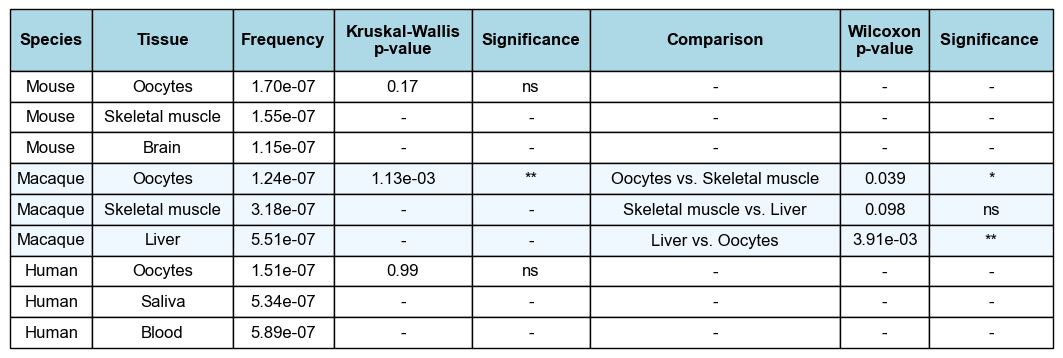

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# Set the default font to Arial
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

def format_long_numbers(df, precision=2):
    """
    Format numbers in the dataframe:
    - Large numbers are formatted with commas (e.g., 1,000,000).
    - Floats smaller than 1 are displayed in scientific notation.
    - Precision for floats is controlled by the 'precision' parameter.
    """
    for col in df.select_dtypes(include=['float64']).columns:
        if 'Fold difference' not in col:
            df[col] = df[col].apply(lambda x: f"{x:,.{precision}f}" if x >= 0.01 else f"{x:.{precision}e}")
    return df

def enforce_line_breaks_in_headers(df, max_width=15):
    """
    Enforces line breaks in column headers by inserting `\n` when the text exceeds `max_width`.
    """
    # Replace spaces with newlines if the text length exceeds max_width
    df.columns = [
        '\n'.join(textwrap.wrap(col, max_width)) if len(col) > max_width else col
        for col in df.columns
    ]
    return df

def export_table_as_png(df, file_prefix="table_custom_header.png", save=True):
    df = df.copy()

    df = format_long_numbers(df)

    # Replace values with "-" if they are the same as the previous row
    for col in ["Kruskal-Wallis p-value"]:
        df[col] = df[col].mask(df[col].duplicated(), "-")
        df[col] = df[col].mask(df[col].duplicated(), "-")
    # Replace "Significance" with '-' if p-value is '-'
    df.loc[df['Kruskal-Wallis p-value'] == '-', 'Significance'] = '-'
    
    df = enforce_line_breaks_in_headers(df)

    # Set the font to Arial and size to 10
    plt.rcParams["font.family"] = "Arial"
    fontsize = 12
    plt.rcParams["font.size"] = fontsize

    # Create the figure for the table
    plt.figure(figsize=(5, 2))  # Adjust size as needed

    # Create a table using pandas' built-in functionality
    ax = plt.gca()
    ax.axis('off')  # Turn off axes
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=['lightgrey']*len(df.columns))

    # Adjust column width.
    table.auto_set_column_width(col=list(range(len(df.columns))))

    # Scale the table (header and row scaling)
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header row
            cell.set_fontsize(fontsize)
            cell.set_text_props(weight='bold')
            cell.set_facecolor('lightblue')  # Optional: Set header row color
            cell.set_height(0.4)  # Increase the height of the header rows
        else:  # Data rows
            cell.set_fontsize(fontsize)
            cell.set_height(0.2)  # Increase the height of the header rows
            cell.set_facecolor('white')  # Optional: Set data row color
            if df.iloc[i-1]["Species"] == "Macaque":  # Check if Species == Macaque
                cell.set_facecolor('#F0F8FF')  # Gainsboro (Light gray)

    if save:
        # Save table as tsv.
        df.to_csv(f'plots/tsv/{file_prefix}.tsv', index=None, sep='\t')
        # Save the figure as a vectorized image.
        plt.savefig(f'plots/png/{file_prefix}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'plots/pdf/{file_prefix}.pdf', dpi=300, bbox_inches='tight')
        # plt.close()

# Export the result of test_kruskal_wallis(df_younger) as an image
kruskal_results_df = test_kruskal_wallis(df_younger)
export_table_as_png(kruskal_results_df, "tableSX_younger_freqs_kruskal_wallis")


# Compute mutation rates (indel frequency per year)

In [18]:
import pandas as pd
from scipy.stats import kruskal,mannwhitneyu
from scipy.stats import ttest_ind

def get_rates(df_in, tissue='M', species1='mouse', species2='macaque'):
    # Get tissue.
    df = df_in.copy()[df_in['Tissue'] == tissue]
    # return df#.value_counts('Species')

    # Compute indel frequency per year
    df['Frequency_per_year'] = df['Frequency'] / df['Age']

    comparison_col = 'Frequency_per_year'
    
    # Perform Shapiro-Wilk test for normality on the frequency distributions by species
    shapiro_results = {}
    for species in [species1, species2]:
        stat, p_value = shapiro(df[df['Species'] == species][comparison_col])
        shapiro_results[species] = {'Shapiro-Wilk Test Statistic': stat, 'p-value': p_value}
    # return pd.DataFrame(shapiro_results)

    # Perform T-test to compare distributions by species
    t_test_results = mannwhitneyu(
        df[df['Species'] == species1][comparison_col],
        df[df['Species'] == species2][comparison_col],
        alternative='greater'
    )
    # return t_test_results

    # # Perform Mann-Whitney U test to compare distributions by species
    # mannwhitney_results = mannwhitneyu(
    #     df[df['Species'] == species1][comparison_col],
    #     df[df['Species'] == species2][comparison_col],
    #     alternative='greater'
    # )
    # return mannwhitney_results

    # Create a DataFrame to display the results
    results_df = pd.DataFrame({
        'Species': [species1.capitalize(), species2.capitalize()],
        'Tissue': ['Skeletal muscle'] * 2,
        'Age group': ['Younger'] * 2,
        'Frequency': [
            df[df['Species'] == species1]['Frequency'].mean(),
            df[df['Species'] == species2]['Frequency'].mean()
        ],
        'Frequency_per_year': [
            df[df['Species'] == species1]['Frequency_per_year'].mean(),
            df[df['Species'] == species2]['Frequency_per_year'].mean()
        ],
        # 'statistic': t_test_results.statistic,
        'p-value': t_test_results.pvalue,
    })
    
    return results_df


get_rates(df_younger)

,Species,Tissue,Age group,Frequency,Frequency_per_year,p-value
0,Mouse,Skeletal muscle,Younger,1.549355e-07,1.859226e-06,0.000019
1,Macaque,Skeletal muscle,Younger,3.179060e-07,1.339581e-07,0.000019


### Using sums of mutations and Nucleotides freqs

In [19]:
def get_rates_2(df_in):
    df = df_in.copy()
    # Summarize # of mutations, nucleotides, ages.
    nucl = df.groupby(['Species','Tissue','Age_group'])['Nucleotides_per_tissue'].sum().reset_index(name='Nucleotides')
    mutx = df.groupby(['Species','Tissue','Age_group'])['No_mutations'].sum().reset_index()
    ages = df.groupby(['Species','Tissue','Age_group'])['Age'].mean().reset_index(name='Mean_age')
    df = pd.merge(pd.merge(mutx,nucl),ages)
    
    # Compute frequencies.
    df['Recomputed_frequency'] = df['No_mutations'] / df['Nucleotides']
    df['Recomputed_frequency_per_year'] = df['Recomputed_frequency'] / df['Mean_age']

    # df = df[df['Tissue']=='M']
    df = df.sort_values('Species',ascending=False)

    return df
    

get_rates_2(df_freqs)
def test_mwu_younger_vs_older(df_in):
    results = []

    # Parameters.
    for species in list_species:
        df = df_in[df_in['Species'] == species]
        tissues = dict_tissues[species]

        for tissue in tissues:
            younger_data = df[(df['Tissue'] == tissue) & (df['Age_group'] == 'Younger')]['Recomputed_frequency']
            older_data = df[(df['Tissue'] == tissue) & (df['Age_group'] == 'Older')]['Recomputed_frequency']

            if len(younger_data) > 0 and len(older_data) > 0:
                mwu_stat, mwu_p_value = mannwhitneyu(younger_data, older_data, alternative='greater')
            else:
                mwu_stat, mwu_p_value = float('nan'), float('nan')

            results.append({
                'Species': species,
                'Tissue': tissue,
                'Fold difference': older_data.median() / younger_data.median(),
                'MWU statistic': mwu_stat,
                'p-value': mwu_p_value
            })

    # Convert results to a DataFrame for easy viewing
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
test_mwu_younger_vs_older(get_rates_2(df_freqs))

,Species,Tissue,Fold difference,MWU statistic,p-value
0,mouse,Oo,1.132880,0.0,1.0
1,mouse,M,2.495904,0.0,1.0
2,mouse,Br,3.073143,0.0,1.0
3,macaque,Oo,0.567462,1.0,0.5
4,macaque,M,2.598570,0.0,1.0
5,macaque,Li,4.892572,0.0,1.0
6,human,Oo,1.060374,0.0,1.0
7,human,Sa,0.993863,1.0,0.5
8,human,Bl,1.146306,0.0,1.0


In [20]:
df_younger.groupby(['Species','Age_group','Tissue'])['Frequency'].median().reset_index().sort_values('Tissue')

,Species,Age_group,Tissue,Frequency
0,human,Younger,Bl,3.107927e-07
7,mouse,Younger,Br,8.922334e-08
3,macaque,Younger,Ht,0.000000e+00
4,macaque,Younger,Li,4.246164e-07
8,mouse,Younger,Li,0.000000e+00
5,macaque,Younger,M,2.497244e-07
9,mouse,Younger,M,1.183090e-07
1,human,Younger,Oo,7.056982e-08
6,macaque,Younger,Oo,9.009502e-08
10,mouse,Younger,Oo,1.452606e-07
